# Statistical models and PPL

In [3]:
# import required libraries
import numpy as np                   
import matplotlib.pyplot as plt  

import time
import sys
import torch
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

## What is a statistical model?

Statistical modelling is all about sampling and probabilities. In a statistical model, calls to random number generators are common, distributions are sampled  from to create events and probabilities of events occuring are evaluated. The same model may produce different outcomes if provided the same starting conditions but a different random number seed. (climate/weather example, diagram to explain this better?)

## Bayesian Statistics in Climate and Weather

In Bayesian statistics, probability is viewed as a degree of belief of an event occurring (in contrast to frequentist statistics where probability is the frequency of an event occurring). The Bayesian view of probability is valuable in climate and weather forecasting. It allows us to quantify how likely we expect an event to be, such as the probability of rain in Exeter this afternoon. 

In Bayesian statistics, we can incorporate a prior probability: our degree of belief of event occurring before observing any evidence. Say its July in Exeter- we would expect rain to be quite unlikely. Then, we observe some evidence and update our degree of belief about the event occurring. Say we look out the window and observe some data: we see there are many dark clouds in the sky. So we can update our degree of belief of rain occurring this afternoon. 

$$P({\sf rain \, later}|{\sf weather\, now\,=cloudy}) =  \frac{P({\sf weather now | \sf rain later}) P({\sf rain later})}{P({\sf weather now})}$$


P(X|Y) is the conditional probability of A, given the observed state of B (clouds in this case). This is often called conditioning on observations.

It turns out this is really useful and has many applications in climate and weather science. One important example is data assimilation: incorporating observed data from satellites about the current state of the atmosphere into the weather model for prediction of the future state of the atmosphere.

One of the advantages of probabilistic programming is that this step is made simpler. We can easily "condition" on observations.


## What is a probabilistic programming language (PPL)?

The traditional approach to constructing statistical models can be time-consuming and requires expertise. Typically it involves statisticians writing down the problem on paper and carrying out a mathematical procedure to design a bespoke statistical model. This would then be translated into code to construct a model ready for use. Since the model is specifically designed for the task at hand, this method must be repeated for each new problem. 

Probabilistic programming languages are designed to make this process simpler, quicker and less technical. The idea is to remove the need for the expert statistician to hand-design the statistical model, by embedding this step within the programming language itself. Statistical tasks such as encoding observations (conditioning) and learning latent variables (inference) are automated and some of the complicated mathematical and statistical steps are hidden from the user. This makes statistical modelling more accessible to non-experts and tasks that traditionally require a lot of thought and hand-engineering can be automated.

More simply, a PPL is an ordinary programming language, equipped with tools that make statistical modelling easier for the user, reducing the need for hand-designing programs. It's useful for analysis and inference from data: not for writing software.

Also, probabilistic programming languages are not new. They have been around since Simula in 1966 [Dahl and Nygaard 1966] However, with the rise of deep learning, they are growing in popularity, with many new PPLs designed with inference for machine learning in mind (pyro, Edward, PyMC3, https://en.wikipedia.org/wiki/Probabilistic_programming)
https://www.cs.ubc.ca/~poole/papers/IndependentChoices.pdf


http://adriansampson.net/doc/ppl.html

## What does Probabalistic Programming involve? 

The main components of a probablistic programming language are:

(1) Sampling: Our model is probabilistic- it requires sampling from probability distributions.
(2) Conditioning: We have some observed data that can be used to update probabilities
(3) Inference: We can learn something from the known data and model. This could be a "latent variable", some underlying factor that you can't directly observe but might influence the data. This is usually the hard part.

Probabalistic programming is a suitable choice when we have a probabalistic model, that relies on sampling from distributions in order to make predictions. PPL makes it easier to do conditioning on observed data and to learn something about the model. 

## Simple Example: Propagate Single Particle

A simple example is a model that propagates a single particle forward in time. We want to infer the speed of propagation. The speed of propagation is drawn from a normal prior, with a prior guess and some variance. From this, the position can be calculated, which is observed with some measurement error.

$${\sf speed} \, | \, {\sf guess} \sim \cal {\sf Normal}({\sf guess}, 1) $$
$$ {\sf position}_{\sf final} = {\sf position}_{\sf initial} + {\sf speed}\times{\sf time}$$
$${\sf position}_{\sf observed} \, | \, {\sf guess}, {\sf speed} \sim {\sf Normal}({\sf position}_{\sf final}, 0.01)$$

Speed is a latent random variable we want to infer. The function for this model is written below

We'll be using pyro (https://pyro.ai/examples/index.html) to  
want to backpropagate some information 
this could be applied to any model- and use for more complicated things

## (1) Probabilistic Model
The first step is building a probabilistic model, which involves the first component of PPL, sampling. A probabilistic model takes samples from a distribution. In pyro we provide a unique name for each variable, which we will see is useful later on.

In [4]:

def propagate(guess=1.,position_0=0.75,time=0.625):
    """ Parameters:
    guess = the user's guess for the speed
    position_0 = initial position 
    time = length of time before observing """
    # get pyro distribution of speed
    speed = pyro.sample("speed", dist.Normal(guess, 0.25))
    # final conditions: wave peak at init - c(dt/dx)*NT
    position_f = position_0 + speed * time
    # final position is observed with a bit of noise
    position_obs = pyro.sample("position",dist.Normal(position_f,0.1))
    return(speed,position_obs)


This is the model. Note the `pyro.sample` statements that allow us to sample from a distribution. This is 

Plot a histogram to check this function returns a different speed and position each time.

speed= tensor(0.8562) , position= tensor(1.2851)
speed= tensor(0.9427) , position= tensor(1.3392)
speed= tensor(1.1096) , position= tensor(1.4435)
speed= tensor(1.0078) , position= tensor(1.3799)
speed= tensor(1.1084) , position= tensor(1.4427)


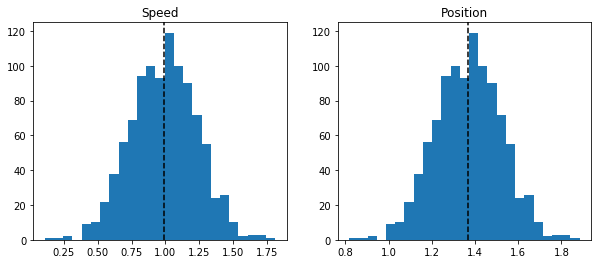

In [21]:
# Check this gives a different position wave every time depending on the speed sampled
for i in range(5):
    speed,pos=propagate()
    print("speed=",speed,", position=",pos)

uncond = [propagate() for i in range(1000)]
speed_uncond,pos_uncond = zip(*uncond)
fig = plt.figure(figsize=(10,4))
ax1 = plt.subplot2grid((1, 2), (0, 0));
ax1.hist(speed_uncond,25);
ax1.axvline(np.mean(speed_uncond),c="k",ls="--");
plt.title('Speed');
ax2 = plt.subplot2grid((1, 2), (0, 1));
ax2.hist(pos_uncond,25);
ax2.axvline(np.mean(pos_uncond),c="k",ls="--");
plt.title('Position');

## 2) Conditioning

What if we observe the particle at a certain point, x=1.8 ? We want to use this information in our model to learn more about the latent variable- speed. This is when we condition on our observations. We need to update our model, so that the outcome is always 1.8. 

In pyro, this is done with the `pyro.condition` statement for the named variable "position". This statement returns a new function almost identical to the original, but overwrites the `pyro.sample("position",...)` by fixing it at the observed value. The rest of the function remains the same. Let's check this:


In [22]:
position_observed = 1.8
conditioned_propagate = pyro.condition(propagate,
                                       data={"position": position_observed})

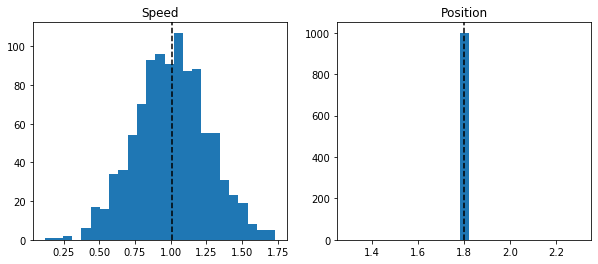

In [23]:
# Check this gives the same position wave every time 
# but a different speed
cond = [conditioned_propagate() for i in range(1000)]
speed_cond,pos_cond = zip(*cond)
fig = plt.figure(figsize=(10,4))
ax1 = plt.subplot2grid((1, 2), (0, 0));
ax1.hist(speed_cond,25);
ax1.axvline(np.mean(speed_cond),c="k",ls="--");
plt.title('Speed');
ax2 = plt.subplot2grid((1, 2), (0, 1));
ax2.hist(pos_cond,25);
ax2.axvline(np.mean(pos_cond),c="k",ls="--");
plt.title('Position');

## 3) Inference
The next step is inference- the difficult part. The aim is to find the posterior distribution of the latent variable, (speed), given the model and the observations.

$$({\sf speed} \, | \, {\sf guess}, {\sf position}_{\sf observed}  = 1.8) \sim \, ? $$


In some scenarios there may be an analytical form of this distribution. But if not, we can use the stochastic variational inference algorithm. This requires a distribution that approximates the posterior distribution, which is called the variational distribution or the "guide" for short. This distribution relies on additional parameters called variational parameters, that will be tuned to "guide" it towards the posterior distribution. 

For this example, the speed is sampled from a normal distribution with mean and variance given by the variational parameters, a and b. These are defined with the statement `pyro.param(...)`. This stores the values of the parameters in something called the "Parameter Store", so they can accessed and updated later. The initial values of a is the guess and the initial value of b is 1. These parameters will be optimised in stochastic variational inference. Also note that the variance, b, is constrained to be positive.

In [5]:
from torch.distributions import constraints
def guide(guess=1.):
    """ The guide (or variational distribution) approximates 
    the posterior distribution, using extra variational parameters,
    a and b, to sample from the speed distribution. """
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.),constraint=constraints.positive)
    speed = pyro.sample("speed", dist.Normal(a,b))
    return speed

We can plot some samples from the guide, in the same way as before. Note that the guide returns the speed as a tensor (hence the  `.item()` to get the values for the histogram).

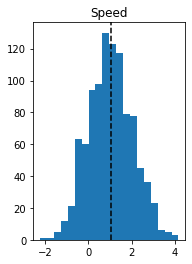

In [6]:
# Check guide distribution by running this function 1000 times
pyro.clear_param_store()
speed_guide = [guide().item() for i in range(1000)]
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0));
ax1.hist(speed_guide,20);
ax1.axvline(np.mean(speed_guide),c="k",ls="--");
plt.title('Speed');

## Pyro Parameters
In the guide, we created Parameters in Pyro using `pyro.param("parameter_name", torch.tensor(parameter_value))`.
These are are thin wrappers around PyTorch Tensors with unique names (see http://docs.pyro.ai/en/0.2.1-release/parameters.html). They are saved in the Pyro Parameter Store, a dictionary of the parameters stored:

In [26]:
param_store = pyro.get_param_store()
print(param_store)
print(param_store.keys())

dict_keys(['a', 'b'])


The values of the parameters can be accessed using the unique parameter names. 

In [27]:
a = param_store.get_param("a")
print(a)

tensor(1., requires_grad=True)


As expected, the value of parameter `a` is the value provided in the guide function. This value can be replaced using the `.replace_param` function.  

In [16]:
param_store.replace_param("a",torch.tensor(2.),a)
a = param_store.get_param("a")
print(a)

tensor(2., requires_grad=True)


Now when we call the guide function, the new value of the parameter is used. The line 

`a = pyro.param("a", torch.tensor(guess))`

inside the guide function will not affect the value of the parameter. This can be checked by sampling from the guide many times.

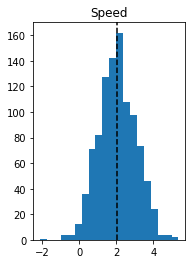

In [17]:
speed_guide = [guide().item() for i in range(1000)]
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0));
ax1.hist(speed_guide,20);
ax1.axvline(np.mean(speed_guide),c="k",ls="--");
plt.title('Speed');

This process is used in the stochastic variational inference, where the parameters are updated in the parameter store at each step, rather than explicitly changing the guide function at each step. Finally, we can reset the values of the parameters using `pyro.clear_param_store()`. 

In [18]:
pyro.clear_param_store()
param_store = pyro.get_param_store()
print(param_store.keys())

dict_keys([])


## Stochastic Variational Inference
We have created a family of guide functions, indexed by named parameters, and want to search for the member of that family that is the best approximation to the posterior distribution, according to some loss function- we'll use the Evidence Lower Bound Operator or "ELBO" (link to why). We use stochastic variational inference , `pyro.infer.SVI`, to optimise the parameters of the guide so that sampling from the guide produces a distribution for `speed` consistent with the model conditioned on observations. 


In [28]:
pyro.clear_param_store()

from pyro.optim import Adam
adam_params = {"lr": 0.001, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

svi = pyro.infer.SVI(model=conditioned_propagate, 
                     guide=guide,
                     optim=optimizer,
                     loss=pyro.infer.Trace_ELBO())

losses, a,b  = [], [], []
num_steps = 10000
for t in range(num_steps):
    losses.append(svi.step())
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())


plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");


AttributeError: 'float' object has no attribute 'dtype'

In [ ]:
print('a = ',pyro.param("a").item())
print('b = ',pyro.param("b").item())

plt.plot(a);
plt.plot(b);

Once converged, we have a value of `a` and `b` that can be used in the guide to sample from the speed given the model and the observations. This is an approximation to the posterior distribution. We can also compare this to the analytic speed, which can be calculated for this simple example:

In [143]:
# compare against analytic speed
peak_0 = 0.75
nt = 25    
dt = .025
speed_analytic = (position_observed - peak_0)/(nt*dt)
print(speed_analytic)

1.6800000000000002


In [144]:
param_store = pyro.get_param_store()
print("Speed | model, obs ~ N({:.2f},{:.2f})".format(
    (param_store.get_param("a").item()),
    (param_store.get_param("b").item() ) ))

Speed | model, obs ~ N(1.68,0.07)


In [145]:
def perfect_guide(guess=1.,position_0=0.75,time=0.625):
    pos_speed = (1.8 - position_0)/time
    v = 0.01/time
    loc =(v**2 * guess + 0.25**2 * pos_speed) / (0.25**2 + v**2) # 1.677
    sd = np.sqrt(v**2/(0.25**2 + v**2)) # 0.0639
    return pyro.sample("speed", dist.Normal(loc, sd))
perfect_guide()

tensor(1.6459)

In [7]:
new_speed_guide = [guide().item() for i in range(1000)]
exact_guide = [perfect_guide().item() for i in range(1000)]

fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0));
ax1.hist(speed_guide,20,alpha=0.75);
ax1.axvline(np.mean(speed_guide),c="k",ls="--");
ax1.hist(exact_guide,20,color="orange",alpha=0.75);
ax1.axvline(1.677,c="orange",ls="--");
plt.title('Initial guide');
plt.axis(xmin= -2.,xmax=6.,ymax=160);
ax2 = plt.subplot2grid((1, 2), (0, 1));
ax2.hist(new_speed_guide,20,alpha=0.75);
ax2.axvline(np.mean(new_speed_guide),c="k",ls="--");
ax2.hist(exact_guide,20,color="orange",alpha=0.75);
ax2.axvline(1.677,c="orange",ls="--");
plt.title('Final guide');
plt.axis(xmin= 1.,xmax=2.5,ymax=160);

NameError: name 'perfect_guide' is not defined

Note the diffrent axes.
There's also an auto-guide option in pyro.

In [150]:
import pyro.contrib
from pyro.contrib.autoguide import AutoDiagonalNormal
autoguide = AutoDiagonalNormal(conditioned_propagate)
svi = pyro.infer.SVI(model=conditioned_propagate, 
                     guide=autoguide,
                     optim=optimizer,
                     loss=pyro.infer.Trace_ELBO())

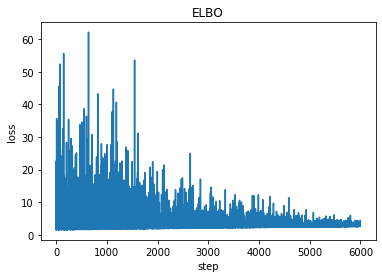

In [152]:
num_steps = 6000
losses = []
for t in range(num_steps):
    losses.append(svi.step())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");

In [153]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

a tensor(1.6813, requires_grad=True)
b tensor(0.0715, grad_fn=<AddBackward0>)
auto_loc tensor([1.6763], requires_grad=True)
auto_scale tensor([0.0199], grad_fn=<AddBackward0>)


## When would this be useful?

This last step, inference, is generally difficult but really useful. It provides us with knowledge of the latent factors underlying the data which can be used for prediction. Inference is a common problem in machine learning, but it often relies on algorithms hand-crafted by experts. Probabilistic programming languages have been around for 





